In [1]:
import plotly.graph_objects as go
import networkx as nx
import os

# reading input log file

test_name = "ddmd"
# test_name = "vist"
# test_name = "seq9f9s"
# test_name = "s9f9p8_0"

stat_path=f"example_stat/{test_name}"
image_path=f"{stat_path}/images"

VFD_ACCESS_SKIP=10

ADD_ADDR=False


In [2]:
# My utility functions
import utils.stat_loader as sload
import utils.stat_print as sp
import utils.vfd_stat2graph as vfd2g
import utils.vfd_graph2sankey as vfd2sk
import utils.full_stat2graph as f2g

# Improve Functions
## TODO
- Add dataset nodes
- Add file address ordering nodes


In [3]:
STAGE_START = 0
STAGE_END = 1


TASK_ORDER_LIST = sload.load_task_order_list(stat_path)
STAGE_END = sload.correct_end_stage(TASK_ORDER_LIST, STAGE_END)

TASK_ORDER_LIST = sload.current_task_order_list(TASK_ORDER_LIST, STAGE_START, STAGE_END)

TASK_LISTS = list(TASK_ORDER_LIST.keys())

print(f"TASK_ORDER_LIST = {TASK_ORDER_LIST}")
TASK_LISTS


TASK_ORDER_LIST = {'openmm': 0, 'aggregate': 1}


['openmm', 'aggregate']

In [4]:
vfd_files = sload.find_files_with_pattern(stat_path, "vfd")
# vfd_files = vfd_files[0:1]
print(f"vfd_files: {vfd_files}")

vfd_dict = sload.load_stat_json(vfd_files)
# print(vfd_dict)


vol_files = sload.find_files_with_pattern(stat_path, "vol")
# vol_files = vol_files[0:1]
print(f"vol_files: {vol_files}")

vol_dict = sload.load_stat_json(vol_files)

print("loading json done")

vfd_files: ['example_stat/ddmd/40876-vfd_data_stat.json', 'example_stat/ddmd/40930-vfd_data_stat.json', 'example_stat/ddmd/40983-vfd_data_stat.json', 'example_stat/ddmd/41036-vfd_data_stat.json', 'example_stat/ddmd/41249-vfd_data_stat.json', 'example_stat/ddmd/41382-vfd_data_stat.json', 'example_stat/ddmd/41515-vfd_data_stat.json', 'example_stat/ddmd/41648-vfd_data_stat.json', 'example_stat/ddmd/41781-vfd_data_stat.json', 'example_stat/ddmd/41914-vfd_data_stat.json', 'example_stat/ddmd/42047-vfd_data_stat.json', 'example_stat/ddmd/42180-vfd_data_stat.json', 'example_stat/ddmd/42528-vfd_data_stat.json', 'example_stat/ddmd/42584-vfd_data_stat.json', 'example_stat/ddmd/42845-vfd_data_stat.json']
loading example_stat/ddmd/40876-vfd_data_stat.json
loading example_stat/ddmd/40930-vfd_data_stat.json
loading example_stat/ddmd/40983-vfd_data_stat.json
loading example_stat/ddmd/41036-vfd_data_stat.json
loading example_stat/ddmd/41249-vfd_data_stat.json
loading example_stat/ddmd/41382-vfd_data_st

In [5]:
# # Show VFD Tracker overhead
# sp.show_all_overhead("VFD", vfd_dict)

In [6]:
def inc_in_dict(dic, k):
    if k not in dic:
        dic[k] = 0
    else:
        dic[k]+=1



G_VFD = nx.DiGraph()
G_VFD = f2g.add_task_dset_file_nodes(G_VFD, vfd_dict, TASK_ORDER_LIST, add_addr=ADD_ADDR)

# sp.display_all_edges_attr(G_VFD)
# sp.display_all_nodes_position(G_VFD)

In [7]:

file_page_nodes_attr, dset_page_edges = f2g.get_file_dset_maps(vfd_dict, TASK_ORDER_LIST)

# for k,v in file_page_nodes_attr.items(): print(f"file_page_nodes_attr: {k} -> {v}")
# for k,v in add_edge_stat.items(): print(f"add_edge_stat: {k} -> {v}")



file_page_nodes_attr: {'[0-49)': {'pos': (0, 0), 'rpos': 0, 'range': (0, 49), 'size': 3211264}, '[49-98)': {'pos': (0, 1), 'rpos': 0, 'range': (49, 98), 'size': 3211264}, '[98-147)': {'pos': (0, 2), 'rpos': 0, 'range': (98, 147), 'size': 3211264}, '[147-196)': {'pos': (0, 3), 'rpos': 0, 'range': (147, 196), 'size': 3211264}}
dset_page_edges: {('contact_map-0-W', '[0-49)'): {'access_cnt': 1560, 'access_type': 'write'}, ('file-0-W', '[0-49)'): {'access_cnt': 192, 'access_type': 'write'}, ('fnc-0-W', '[0-49)'): {'access_cnt': 1560, 'access_type': 'write'}, ('point_cloud-0-W', '[0-49)'): {'access_cnt': 228, 'access_type': 'write'}, ('rmsd-0-W', '[0-49)'): {'access_cnt': 1560, 'access_type': 'write'}, ('[0-49)', 'contact_map-1-R'): {'access_cnt': 60, 'access_type': 'read'}, ('contact_map-1-W', '[49-98)'): {'access_cnt': 2, 'access_type': 'write'}, ('contact_map-1-W', '[98-147)'): {'access_cnt': 16, 'access_type': 'write'}, ('[0-49)', 'file-1-R'): {'access_cnt': 96, 'access_type': 'read'}, (

In [8]:
def update_nodes_edges(G,add_edge_stat, edges_to_remove, nodes_to_add):
    G.remove_edges_from(edges_to_remove)
    
    G.add_edges_from(add_edge_stat.keys())
    nx.set_edge_attributes(G, add_edge_stat)
    
    for page_nodes in nodes_to_add:
        G.add_node(page_nodes, pos=nodes_to_add[page_nodes][page_nodes]['pos'])
        page_node_attrs = {page_nodes: {'rpos':nodes_to_add[page_nodes][page_nodes]['rpos'], 'phase': nodes_to_add[page_nodes][page_nodes]['phase'], 'type':nodes_to_add[page_nodes][page_nodes]['type'], 'size': nodes_to_add[page_nodes][page_nodes]['size'], 'range': nodes_to_add[page_nodes][page_nodes]['range']}}
        nx.set_node_attributes(G, page_node_attrs)
        # print added new node
        print(f"add new node: {page_nodes} -> {G.nodes[page_nodes]}")
    return G

if ADD_ADDR:
    add_edge_stat,edges_to_remove,nodes_to_add = f2g.add_file_page(G_VFD, file_page_nodes_attr, dset_page_edges)
    G_VFD = update_nodes_edges(G_VFD,add_edge_stat, edges_to_remove, nodes_to_add)

    print(f"edges_to_remove: {edges_to_remove}")

edge_types: {'file-dset', 'dset-file', 'dset-task', 'task-dset'}


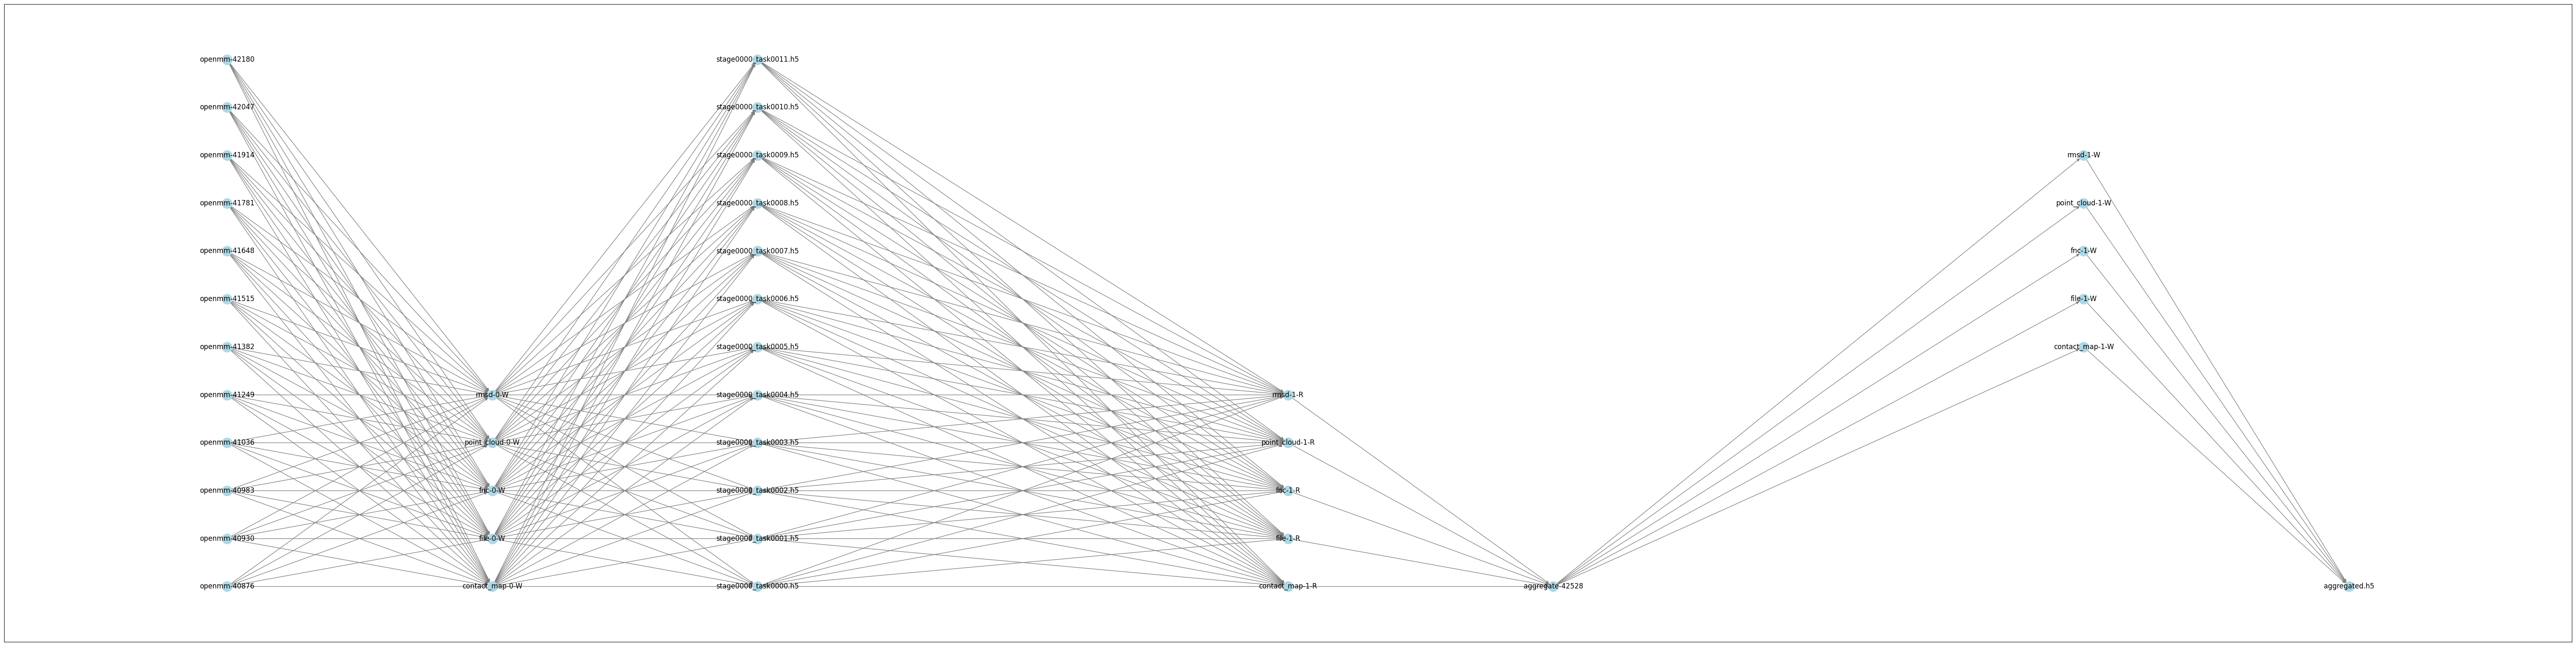

In [9]:
# G_VFD = vfd2g.set_task_position_full(G_VFD, task_file_map, STAGE_START)
# sp.display_all_nodes_attr(G_VFD)
all_edge_types = nx.get_edge_attributes(G_VFD,'edge_type')
edge_types = []
for edge in all_edge_types:
    edge_types.append(all_edge_types[edge])

print(f"edge_types: {set(edge_types)}")

sp.draw_graph(G_VFD, test_name, stat_path, graph_type="vfd", prefix=f'{(STAGE_END+1)}s', save=True)

In [10]:
# sp.display_all_edges_attr(G_VFD)
# sp.display_all_nodes_position(G_VFD)

# Add networkx to Sankey diagram

## Statistics for Sankey
Below are needed edge attributes before generating the sankey diagram:
- access_cnt : The total file/dataset access count 
- access_size : The total read and write access size
- operation : The operation type : read, write, read_write
- bandwidth : Get the per access size and time, then calculate the bandwidth. Average the bandwidth if multiple accesses. (TODO: currently only recording one access size and time)




In [11]:
if ADD_ADDR: f2g.prepare_sankey_stat_full(G_VFD, vol_dict)
else: f2g.prepare_sankey_stat_no_addr(G_VFD, vol_dict)
    
vfd2sk.time_to_file_x_pos(G_VFD)

UnboundLocalError: local variable 'access_time_in_sec' referenced before assignment

In [ ]:
vfd_nodes, vfd_nodes_dict = vfd2sk.get_nodes_for_sankey(G_VFD, rm_tags=["-R", "-W"], label_on=True)

# print(vfd_nodes)

vfd_links = vfd2sk.get_links_for_sankey(G_VFD, vfd_nodes_dict, val_sqrt=False)
fig = go.Figure(go.Sankey(
            node = vfd_nodes,
            link = vfd_links, orientation='h'))

width = 1400
height = 800

fig.update_layout(
    autosize=False,
    width=width,
    height=height,
    margin=dict(
        l=width/10,
        r=width/10,
        b=height/10,
        t=height/4,
        # pad=2
    ),
    font=dict(size=18),
)


fig.show()
save_html_path = f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-labeled-s4.html"
fig.write_html(save_html_path)
print(f"Sankey saved to {save_html_path}")

bandwidth range: 0.05 B/s ~ 45448858029685680975235537908909777823254990592630084254785818630994536124471736140779409319507429060579142862733574144 PB/s


Sankey saved to example_stat/seq9f9s/vfd-4s-seq9f9s-sankey-labeled-s4.html


In [ ]:
stat_str = sp.show_vfd_stats(G_VFD)
print(stat_str)



Total number of links: 126
Total I/O size: 11.18 MB
Total I/O count: 4142
Total bandwidth: 45448863508108460648382699772236853219660147078533622296583765059085138247160525615938404074227651840378697934314668032 PB/s
Average I/O size: 2.7 KB
Medium I/O size: 6.81 KB
Inital input size: 0



In [ ]:
# Create a manual legend using annotations.

def add_legend_to_graph(fig,save_img=False):
    LEGEND_ITEMS = {
        "Tasks":{"color":"red", "text":"Tasks"},
        "Files":{"color":"blue", "text":"Files"},
        "Edges":{"color":"lightblue", "text":"File bandwidth, darker the color, higher the bandwidth"},
    }

    legend_items = [
        go.layout.Annotation(
            x=0.9,  # X-coordinate for legend item
            y=0.85 - i * 0.03,  # Y-coordinate for legend item (adjust for position)
            xref='paper',
            yref='paper',
            text=f"{item_type} - {LEGEND_ITEMS[item_type]['color']}",
            showarrow=False,
            font=dict(size=14, color=LEGEND_ITEMS[item_type]['color']),
            # bordercolor='grey',  # Set the border color for the legend box
            # borderwidth=1,  # Set the border width for the legend box
            bgcolor='rgba(255, 255, 255, 0.7)',  # Add a transparent background color
        )
        for i, item_type in enumerate(LEGEND_ITEMS.keys())
    ]
    fig.update_layout(annotations=legend_items)
    fig.show()
    if save_img:
        fig.write_html(f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-annotated.html")
